### Generative model + Discriminative model

A generative model captures the data distribution, while a discriminative model serves to estimate the likelihood of a given sample. Multiple operations  involved:
- The generator takes a sample and generates new content
- The new data, along with the real data, is presented to the discriminator
- The discriminator classifies each sample
- Both the generator and discriminator receive feedback
- The discriminator adapts to improve its ability to identify samples, and the generator enhances its ability to generate new data/samples
- An equilibrium is reached where neither model can further improve

In mathematical terms, let:
- $G$ be the generator model - $D$ be the discriminator model
- $z$ be a random noise vector (input to $G$).
- $x$ be a real data sample - $G(z)$ be the generated data.

The discriminator aims to maximize:

  - $D(x) \approx 1 \quad \text{and} \quad D(G(z)) \approx 0$

    The generator aims to minimize $D(G(z))$

  - The overall objective can be expressed as a minimax alg. $\min_G \max_D

  $V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)} [\log (1 - D(G(z)))]$

  where $p_{data}(x)$ is the real data distribution and $p_{z}(z)$ is the noise distribution$

#### Example: Number Generation
Generate a sequence of numbers given a pattern, build a generator and a
discriminator, train and assess the performance of GAN by either visualization
or measuring the divergence between generated sample distribution and the
real data distribution.

Let's first work with the data - a pair of data $(x, y)$ that have a relationship between $x$ and $y$ that is a function of exponential growth.

We generate the data points $(x, y)$ such that $y = 1.1^x$, and for any other content i.e., sequences - integers or images we follow same steps.


In [ ]:
import torch, torchvision, torchaudio
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.__version__, torchvision.__version__, torchaudio.__version__,

('2.5.1+cu124', '0.20.1+cu124', '2.5.1+cu124')

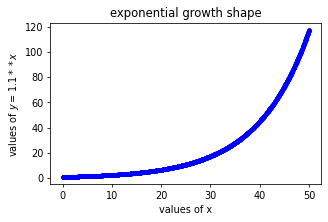

In [11]:
torch.manual_seed(0)
observations = 4096
train_data = torch.zeros((observations, 2))
train_data[:,0] = 50*torch.rand(observations)
train_data[:,1] = 1.1**train_data[:,0] #+ 0.1*torch.rand(observations)
import matplotlib.pyplot as plt
figure = plt.figure(dpi=70, figsize=(5,3))
plt.plot(train_data[:,0], train_data[:,1], '.', c='b')
plt.xlabel('values of x')
plt.ylabel('values of $y=1.1**x$')
plt.title('exponential growth shape')
plt.show()

In [ ]:
''' training dataset '''
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
next(iter(train_loader))[:2]

In [13]:
''' create the generative adversarial network '''
discriminator_d = nn.Sequential(
  nn.Linear(2, 256), nn.ReLU(), nn.Dropout(0.3),
  nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
  nn.Linear(128, 64),  nn.ReLU(), nn.Dropout(0.3),
  nn.Linear(64, 1), nn.ReLU(), nn.Sigmoid().to(device))

generator_g = nn.Sequential(
  nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 32), nn.ReLU(),
  nn.Linear(32, 2).to(device) )

loss_fn = nn.BCELoss()
lr = 0.0005
opt_d = torch.optim.Adam(discriminator_d.parameters(), lr=lr)
opt_g = torch.optim.Adam(generator_g.parameters(), lr=lr)

mse = nn.MSELoss()
def performance(fake_samples):
  real = 1.1**fake_samples[:, 0]
  mseloss = mse(fake_samples[:, 1], real)
  return mseloss

class EarlyStop:
  def __init__(self, patience=1000):
    self.patience = patience
    self.steps = 0
    self.min_loss = float('inf')
  def stop(self, loss):
    if loss < self.min_loss:
      self.min_loss = loss
      self.steps = 0
    elif loss >= self.min_loss:
      self.steps +=1
    if self.steps >= self.patience:
      return True
    else:
      return False

stopper = EarlyStop()

In [14]:
''' train the GAN '''
real_labels = torch.ones((batch_size, 1)).to(device)
fake_labels = torch.zeros((batch_size, 1)).to(device)

def train_discriminator_on_real(real_samples):
  real_samples = real_samples.to(device)
  opt_d.zero_grad()
  out_discriminator = discriminator_d(real_samples)
  loss_discriminator = loss_fn(out_discriminator, real_labels)
  loss_discriminator.backward()
  opt_d.step()
  return loss_discriminator

def train_discriminator_on_fake():
  # noise = torch.rand(batch_size, 2)
  fake_samples = generator_g(torch.rand(batch_size, 2)).to(device)
  opt_d.zero_grad()
  out_discriminator = discriminator_d(fake_samples)
  loss_discriminator = loss_fn(out_discriminator, fake_labels)
  loss_discriminator.backward()
  opt_d.step()
  return loss_discriminator

def train_generator():
  fake_samples = generator_g(torch.rand(batch_size, 2)).to(device)
  opt_g.zero_grad()
  out_generator = discriminator_d(fake_samples)
  loss_generator = loss_fn(out_generator, real_labels)
  loss_generator.backward()
  opt_g.step()
  return loss_generator, fake_samples

epoch 1,  G-loss: 0.706297843686996, D-loss: 0.7993892546622984


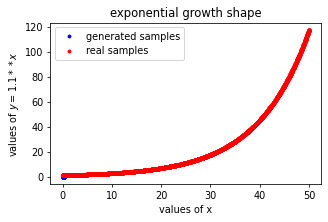

epoch 250,  G-loss: 0.6511559640207598, D-loss: 1.3350085596884451


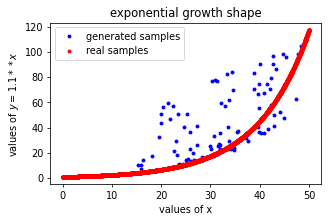

epoch 500,  G-loss: 0.6552942337528351, D-loss: 1.3970474735383065


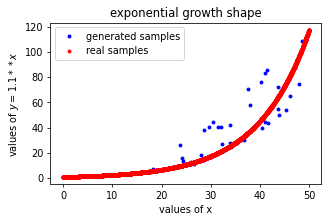

epoch 750,  G-loss: 0.6831132211992818, D-loss: 1.3775197921260711


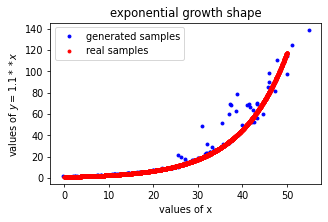

epoch 1000,  G-loss: 0.6993446965371409, D-loss: 1.3056121333952873


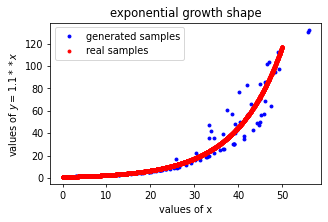

In [15]:
os.makedirs('files', exist_ok=True)
def test_epoch(epoch, generator_loss, discriminator_loss, n, fake_samples):
  if epoch ==0 or (epoch+1)%250 ==0:
    gloss = generator_loss.item()/n
    dloss = discriminator_loss.item()/n
    print(f'epoch {epoch+1},  G-loss: {gloss}, D-loss: {dloss}')
    fake = fake_samples.detach().cpu().numpy()
    figure = plt.figure(dpi=70, figsize=(5,3))
    plt.plot(fake[:, 0], fake[:, 1], '.', c='b', label='generated samples')
    plt.plot(train_data[:,0], train_data[:,1], '.', c='r', label='real samples')
    plt.xlabel('values of x')
    plt.ylabel('values of $y=1.1**x$')
    plt.title('exponential growth shape')
    plt.legend()
    plt.savefig(f'epoch{epoch+1}.png')
    plt.show()

for epoch in range(10000):
  generator_loss, discriminator_loss = 0, 0
  for n, real_samples in enumerate(train_loader):
    loss_d = train_discriminator_on_real(real_samples)
    discriminator_loss += loss_d
    loss_d = train_discriminator_on_fake()
    discriminator_loss += loss_d
    loss_g, fake_samples = train_generator()
    generator_loss += loss_g
  test_epoch(epoch, generator_loss, discriminator_loss, n, fake_samples)
  gdiff = performance(fake_samples).item()
  if stopper.stop(gdiff) == True:
    break

#### Generating numbers

In [ ]:
def onehotencoding(position, depth):
  onehot = torch.zeros(depth,)
  onehot[position] = 1
  return onehot
def inttoonehot(number):
  return onehotencoding(number, 100)
def onehottoint(onehot):
  return torch.argmax(onehot).item()
def generateseq():
  indices = torch.randint(0, 20, (10,))
  return indices*3
def generatebatch():
  batch = np.array([inttoonehot(i).numpy() for i in generateseq() ])
  return torch.tensor(batch)
def datatonumbers(data):
  return torch.argmax(data, dim=-1)
datatonumbers(generatebatch())

In [ ]:
discriminator_ = nn.Sequential(nn.Linear(100, 1), nn.Sigmoid()).to(device)
generator_ = nn.Sequential(nn.Linear(100, 100), nn.ReLU()).to(device)
loss_fn = nn.BCELoss()
lr = 0.0001
opt_d = torch.optim.Adam(discriminator_.parameters(), lr=lr)
opt_g = torch.optim.Adam(generator_.parameters(), lr=lr)

real_ = torch.ones((10, 1)).to(device)
fake_ = torch.zeros((10, 1)).to(device)

In [ ]:
def train_dg(discriminator_, generator_, loss_fn, opt_d, opt_g):
  ''' generate examples of real data '''
  true_data = generatebatch().to(device)
  preds_ = discriminator_(true_data)
  loss_d1 = loss_fn(preds_, real_.reshape(10,1))
  opt_d.zero_grad()
  loss_d1.backward()
  opt_d.step()
  ''' train discriminator on fake data '''
  noise = torch.randn(10, 100).to(device)
  generated_data = generator_(noise)
  preds_ = discriminator_(generated_data)
  loss_d2 = loss_fn(preds_, fake_.reshape(10, 1))
  opt_d.zero_grad()
  loss_d2.backward()
  opt_d.step()
  ''' train generator '''
  noise = torch.randn(10, 100).to(device)
  generated_data = generator_(noise)
  preds_ = discriminator_(generated_data)
  loss_g = loss_fn(preds_, real_.reshape(10,1))
  opt_g.zero_grad()
  loss_g.backward()
  opt_g.step()
  return generated_data

In [ ]:
stopper = EarlyStop(800)
mse = nn.MSELoss()
real_labels = torch.ones((10, 1)).to(device)
fake_labels = torch.zeros((10, 1)).to(device)
def distance(generated_data):
  numbers_ = datatonumbers(generated_data)
  remainders = numbers_ % 5
  tenzeros = torch.zeros((10, 1)).to(device)
  mseloss = mse(remainders, tenzeros)
  return mseloss

for i in range(10000):
  gloss, dloss = 0, 0
  generated_data = train_dg(discriminator_, generator_, loss_fn, opt_d, opt_g)
  distance_ = distance(generated_data)
  if stopper.stop(distance_) == True:
    break
  if i %100 ==0:
    print(f'epoch {i+1}, distance: {distance_}', datatonumbers(generated_data) )

In [ ]:
''' we're saving the model

torch.save(discriminator_.state_dict(), 'discriminator.pt')
torch.save(generator_.state_dict(), 'generator.pt')
'''

torch.jit.script(discriminator_).save('discriminator.pt')
torch.jit.script(generator_).save('generator.pt')

In [ ]:
''' With GANs trained we can discard the discriminator network and use
the Generator only. It can be loaded on device CPU or CUDA enabled. '''
new_generator_ = torch.jit.load('generator.pt')
new_discriminator_ = torch.jit.load('discriminator.pt')
new_generator_.eval(), new_discriminator_.eval()

(RecursiveScriptModule(
   original_name=Sequential
   (0): RecursiveScriptModule(original_name=Linear)
   (1): RecursiveScriptModule(original_name=ReLU)
 ),
 RecursiveScriptModule(
   original_name=Sequential
   (0): RecursiveScriptModule(original_name=Linear)
   (1): RecursiveScriptModule(original_name=Sigmoid)
 ))

In [ ]:
''' obtain inputs from latent space '''
torch.manual_seed(42)
noise = torch.randn(10, 100).to(device)
generated_data = new_generator_(noise)
generated_data, datatonumbers(generated_data)

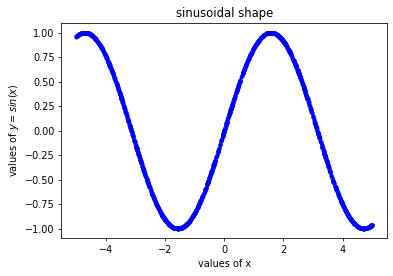

In [ ]:
''' another example '''
torch.manual_seed(0)
observations = 2048
train_data = torch.zeros((observations, 2))
train_data[:,0] = 10*(torch.rand(observations) -0.5)
train_data[:,1] = torch.sin(train_data[:,0])
figure = plt.figure(dpi=70, figsize=(6,4))
plt.plot(train_data[:,0], train_data[:,1], '.', c='b')
plt.xlabel('values of x')
plt.ylabel('values of $y=sin(x)$')
plt.title('sinusoidal shape')
plt.show()

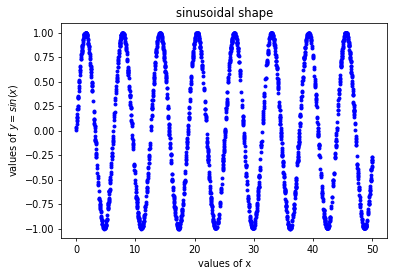

In [ ]:
torch.manual_seed(0)
observations = 2048
train_data = torch.zeros((observations, 2))
train_data[:,0] = 50*(torch.rand(observations))
train_data[:,1] = torch.sin(train_data[:,0])
figure = plt.figure(dpi=70, figsize=(6,4))
plt.plot(train_data[:,0], train_data[:,1], '.', c='b')
plt.xlabel('values of x')
plt.ylabel('values of $y=sin(x)$')
plt.title('sinusoidal shape')
plt.show()